# Exoplanet Machine Learning Exploration

### Import Dependencies

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


## Pre-processing Data

### Data Exploration and Cleaning

In [3]:
# Reading dataset
df = pd.read_csv("data/exoplanet_data.csv")
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [4]:
df.dtypes
# all are numbers expect koi_disp

koi_disposition       object
koi_fpflag_nt          int64
koi_fpflag_ss          int64
koi_fpflag_co          int64
koi_fpflag_ec          int64
koi_period           float64
koi_period_err1      float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err1      float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_depth_err1       float64
koi_depth_err2       float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq                int64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2       float64
koi_model_snr        float64
koi_tce_plnt_num       int64
koi_steff              int64
koi_steff_err1         int64
koi_steff_err2         int64
koi_slogg            float64
koi_slogg_err1       float64
koi_slogg_err2

In [5]:
# checking unique values 
types = df["koi_disposition"].unique()
types

array(['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'], dtype=object)

In [6]:
# checking for nans
df.isnull().sum()

koi_disposition      0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_period_err1      0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err1      0
koi_impact_err2      0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_depth_err1       0
koi_depth_err2       0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_tce_plnt_num     0
koi_steff            0
koi_steff_err1       0
koi_steff_err2       0
koi_slogg            0
koi_slogg_err1       0
koi_slogg_err2       0
koi_srad             0
koi_srad_err1        0
koi_srad_err2        0
ra                   0
dec                  0
koi_kepmag           0
dtype: int64

According to the data source, all columns with the ending "err" contain some kind of error or uncertainty therefore I will exclude them for this model. 

In [7]:
df = df[['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 
       'koi_time0bk', 'koi_impact',
       'koi_duration',
       'koi_depth', 'koi_prad', 
       'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg', 
       'koi_srad', 'ra', 'dec',
       'koi_kepmag']]


### Selecting features 

This project focuses on classifying the Kepler objects based on collected data. The koi_disposition is the target for this determination.

In [8]:
# Set x as every column except koi_dis
X = df.drop("koi_disposition", axis=1)
# Set y to koi_dis
y = df["koi_disposition"]

### Looking into data stats 

In [9]:
# Looking at the stats for the data
X.describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
count,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6.991000e+03,6991.000000,6991.000000,6.991000e+03,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000
mean,0.157059,0.244743,0.202975,0.125018,56.191248,164.488820,0.730631,5.549368,2.391190e+04,121.194193,1095.152768,8.263769e+03,276.038764,1.233729,5700.682449,4.305049,1.740749,292.082406,43.812143,14.271508
std,0.363882,0.429966,0.402243,0.330763,117.570962,67.020475,3.346956,6.425205,8.241240e+04,3519.737626,856.234809,1.775255e+05,824.788481,0.650089,802.060405,0.439238,5.903415,4.762908,3.606167,1.350802
min,0.000000,0.000000,0.000000,0.000000,0.259820,120.515914,0.000000,0.167000,7.500000e+00,0.140000,92.000000,2.000000e-02,1.600000,1.000000,2661.000000,0.047000,0.109000,279.856080,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,2.620126,132.683917,0.198000,2.446000,1.604000e+02,1.400000,554.000000,2.227000e+01,12.400000,1.000000,5297.000000,4.209000,0.829000,288.704730,40.797760,13.455000
50%,0.000000,0.000000,0.000000,0.000000,8.947426,136.739230,0.539000,3.793000,4.245000e+02,2.420000,888.000000,1.466700e+02,23.700000,1.000000,5757.000000,4.436000,0.999000,292.314760,43.679661,14.534000
75%,0.000000,0.000000,0.000000,0.000000,34.282605,169.937005,0.891000,6.197500,1.533250e+03,15.965000,1397.500000,9.006700e+02,82.250000,1.000000,6110.000000,4.543000,1.357000,295.888550,46.693659,15.322000
max,1.000000,1.000000,1.000000,1.000000,1071.232624,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07,9054.700000,8.000000,15896.000000,5.364000,180.013000,301.720760,52.336010,19.065000


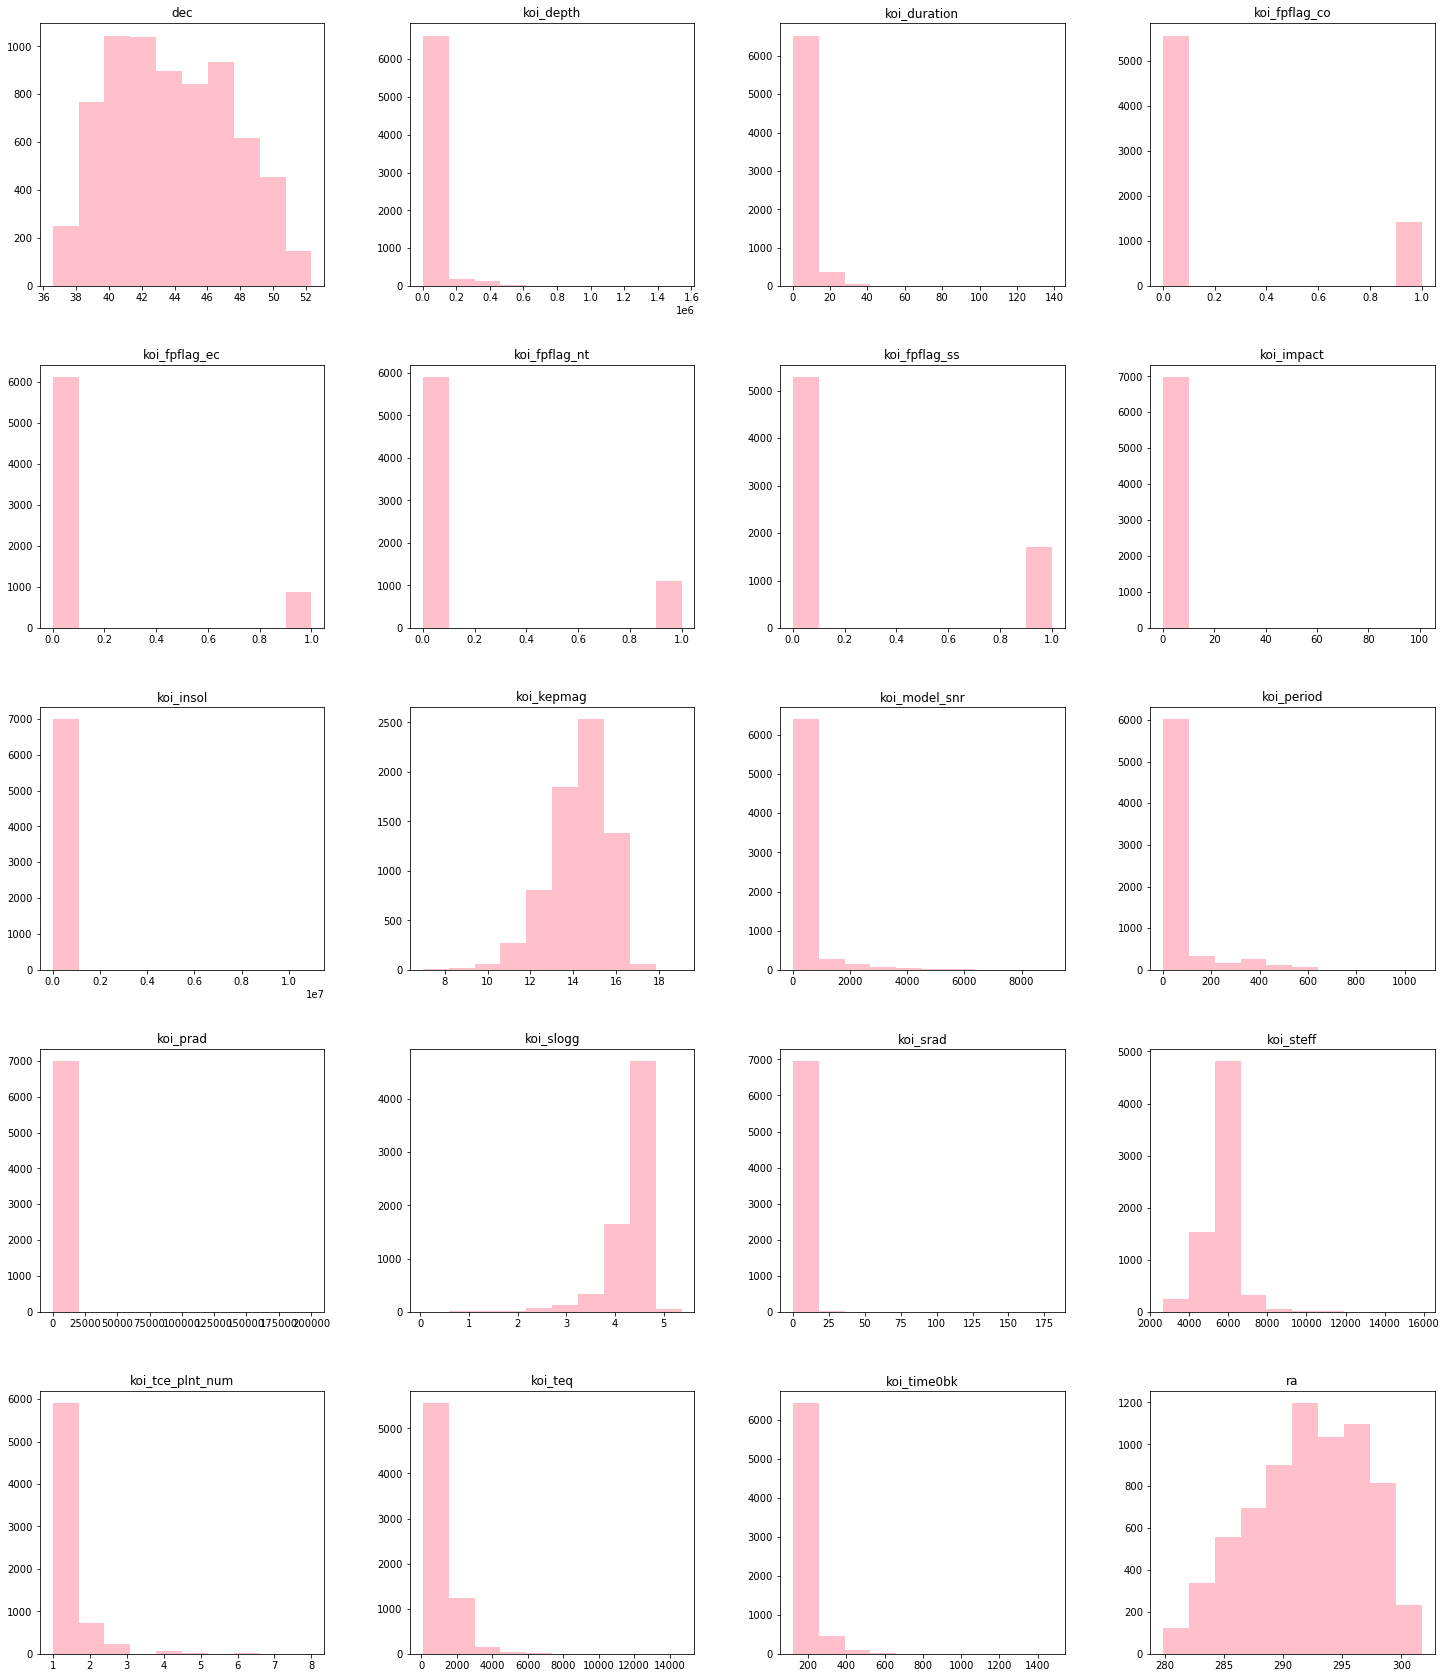

In [10]:
X.hist(figsize=(25,30), color="pink", grid=False);

### Determining feature importance using Random Forest Classifer

In [11]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X,y)

# Get the most important features
importances = rf.feature_importances_

# We can sort the features by their importance
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.12914776274721462, 'koi_fpflag_co'),
 (0.1283664303490843, 'koi_model_snr'),
 (0.12248955366935715, 'koi_fpflag_nt'),
 (0.1017897150287579, 'koi_fpflag_ss'),
 (0.09100415170611317, 'koi_prad'),
 (0.0477389850305429, 'koi_depth'),
 (0.0443598179116974, 'koi_fpflag_ec'),
 (0.039674691486562934, 'koi_period'),
 (0.037703746431715326, 'koi_impact'),
 (0.03335831747825688, 'koi_teq'),
 (0.03318897868957833, 'koi_insol'),
 (0.02955656610822374, 'koi_duration'),
 (0.028189799685458875, 'koi_time0bk'),
 (0.02179086061002392, 'koi_steff'),
 (0.021232197808577467, 'ra'),
 (0.021079030982372973, 'koi_srad'),
 (0.02079859785633287, 'koi_kepmag'),
 (0.02031514086197759, 'koi_slogg'),
 (0.019804888851809543, 'dec'),
 (0.008410766706342112, 'koi_tce_plnt_num')]

In [12]:
# Chosing the top important features
X = df[['koi_fpflag_co', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_model_snr', 'koi_prad']]

## Creating a Train Test Split

In [13]:
# split the data up between training and testing data (3/4:1/4)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
X_train.head()

,koi_fpflag_co,koi_fpflag_nt,koi_fpflag_ss,koi_model_snr,koi_prad
6122,0,0,0,10.8,1.24
6370,0,0,1,13.8,0.86
2879,0,1,0,254.3,3.21
107,0,0,0,38.4,2.25
29,0,0,0,696.5,12.21


## Scaling the data

In [15]:
# Scaling data
# do not scale Y because it is categorical 
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Creating Models & Tuning Hyperparameters



### Logistic Regression Model

Logistic Regression is used when the dependent variable(target) is categorical.

In [16]:
# Create a Logistic Regression Model
logistic_classifier = LogisticRegression(max_iter = 1000)
logistic_classifier

LogisticRegression(max_iter=1000)

In [17]:
# Set up hyperparameter grid 
param_grid = {'C': [1, 5, 10, 50],
              'penalty': ('l2', 'none')}

# Set up the grid search
logistic = GridSearchCV(logistic_classifier, param_grid, verbose=3)

In [18]:
# Fit the model using the grid search estimator. 
logistic.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=1, penalty=l2, score=0.785, total=   0.7s
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ..................... C=1, penalty=l2, score=0.776, total=   0.9s
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ..................... C=1, penalty=l2, score=0.761, total=   0.7s
[CV] C=1, penalty=l2 .................................................
[CV] ..................... C=1, penalty=l2, score=0.778, total=   0.4s
[CV] C=1, penalty=l2 .................................................
[CV] ..................... C=1, penalty=l2, score=0.774, total=   0.3s
[CV] C=1, penalty=none ...............................................
[CV] ................... C=1, penalty=none, score=0.788, total=   0.4s
[CV] C=1, penalty=none ...............................................
[CV] ................... C=1, penalty=none, score=0.777, total=   0.4s
[CV] C=1, penalty=none ...............................................
[CV] ................... C=1, penalty=none, score=0.763, total=   0.5s
[CV] C=1, penalty=none ...............................................
[CV] ................... C=1, penalty=none, score=0.781, total=   0.9s
[CV] C=1, penalty=none ...............................................
[CV] .

/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................... C=5, penalty=none, score=0.788, total=   0.4s
[CV] C=5, penalty=none ...............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................... C=5, penalty=none, score=0.777, total=   0.4s
[CV] C=5, penalty=none ...............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................... C=5, penalty=none, score=0.763, total=   0.5s
[CV] C=5, penalty=none ...............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................... C=5, penalty=none, score=0.781, total=   0.9s
[CV] C=5, penalty=none ...............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................... C=5, penalty=none, score=0.775, total=   0.4s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.789, total=   0.9s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.776, total=   0.5s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.764, total=   0.8s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.778, total=   1.1s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.775, total=   0.4s
[CV] C=10, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, score=0.788, total=   0.5s
[CV] C=10, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, score=0.777, total=   0.4s
[CV] C=10, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, score=0.763, total=   0.6s
[CV] C=10, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, score=0.781, total=   0.9s
[CV] C=10, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, score=0.775, total=   0.3s
[CV] C=50, penalty=l2 ................................................
[CV] .................... C=50, penalty=l2, score=0.786, total=   0.4s
[CV] C=50, penalty=l2 ................................................
[CV] .................... C=50, penalty=l2, score=0.776, total=   0.3s
[CV] C=50, penalty=l2 ................................................
[CV] .................... C=50, penalty=l2, score=0.764, total=   0.6s
[CV] C=50, penalty=l2 ................................................
[CV] .................... C=50, penalty=l2, score=0.778, total=   0.4s
[CV] C=50, penalty=l2 ................................................
[CV] .................... C=50, penalty=l2, score=0.774, total=   0.2s
[CV] C=50, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=50, penalty=none, score=0.788, total=   0.4s
[CV] C=50, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=50, penalty=none, score=0.777, total=   0.4s
[CV] C=50, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=50, penalty=none, score=0.763, total=   0.5s
[CV] C=50, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=50, penalty=none, score=0.781, total=   1.0s
[CV] C=50, penalty=none ..............................................


/Users/kasiakalemba/opt/anaconda3/envs/PythonData2020_2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=50, penalty=none, score=0.775, total=   0.4s


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   21.3s finished


GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1, 5, 10, 50], 'penalty': ('l2', 'none')},
             verbose=3)

In [19]:
# List the best parameters for this dataset
print(logistic.best_params_)

# List the best score
print(logistic.best_score_)

{'C': 1, 'penalty': 'none'}
0.7766549749306865


In [20]:
# Score the model
logistic_model = logistic.best_estimator_
print(f"Logistic Model Training Data Score: {logistic_model.score(X_train_scaled, y_train)}")
print(f"Logistic Model Testing Data Score: {logistic_model.score(X_test_scaled, y_test)}")

Logistic Model Training Data Score: 0.7379362960137326
Logistic Model Testing Data Score: 0.7437070938215103


### SVM Model

"In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well." - www.analyticsvidhya.com

In [21]:
# creates SVC model
svm_model = SVC(kernel='linear')
svm_model

SVC(kernel='linear')

In [22]:
# sets up hyperparameter grid
param_grid = {'C': [1, 5, 10, 50], 
             'gamma': [1,5,10,50,100]}

# grid search
svm_grid = GridSearchCV(svm_model, param_grid, verbose=3)

In [23]:
# fits the model
svm_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.742, total=   0.2s
[CV] C=1, gamma=1 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........................ C=1, gamma=1, score=0.733, total=   0.2s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.743, total=   0.1s
[CV] C=1, gamma=1 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ........................ C=1, gamma=1, score=0.735, total=   0.1s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.738, total=   0.2s
[CV] C=1, gamma=5 ....................................................
[CV] ........................ C=1, gamma=5, score=0.742, total=   0.1s
[CV] C=1, gamma=5 ....................................................
[CV] ........................ C=1, gamma=5, score=0.733, total=   0.1s
[CV] C=1, gamma=5 ....................................................
[CV] ........................ C=1, gamma=5, score=0.743, total=   0.2s
[CV] C=1, gamma=5 ....................................................
[CV] ........................ C=1, gamma=5, score=0.735, total=   0.1s
[CV] C=1, gamma=5 ....................................................
[CV] ........................ C=1, gamma=5, score=0.738, total=   0.1s
[CV] C=1, gamma=10 ...................................................
[CV] .

[CV] ...................... C=10, gamma=10, score=0.765, total=   0.2s
[CV] C=10, gamma=10 ..................................................
[CV] ...................... C=10, gamma=10, score=0.731, total=   0.1s
[CV] C=10, gamma=10 ..................................................
[CV] ...................... C=10, gamma=10, score=0.740, total=   0.2s
[CV] C=10, gamma=50 ..................................................
[CV] ...................... C=10, gamma=50, score=0.741, total=   0.3s
[CV] C=10, gamma=50 ..................................................
[CV] ...................... C=10, gamma=50, score=0.735, total=   0.1s
[CV] C=10, gamma=50 ..................................................
[CV] ...................... C=10, gamma=50, score=0.765, total=   0.3s
[CV] C=10, gamma=50 ..................................................
[CV] ...................... C=10, gamma=50, score=0.731, total=   0.1s
[CV] C=10, gamma=50 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.2s finished


GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 5, 10, 50], 'gamma': [1, 5, 10, 50, 100]},
             verbose=3)

In [24]:
# best parameters for the grid search
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'C': 5, 'gamma': 1}
0.7547176882381621


In [25]:
# SVM Score
svm_model = svm_grid.best_estimator_
print(f"SVM Training Data Score: {svm_model.score(X_train_scaled, y_train)}")
print(f"SVM Testing Data Score: {svm_model.score(X_test_scaled, y_test)}")

SVM Training Data Score: 0.743467480450124
SVM Testing Data Score: 0.7145308924485125


### Random Forest Model

"Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction." - TDS

In [26]:
# set up random forest model
rf_model = RandomForestClassifier()
rf_model

RandomForestClassifier()

In [27]:
# sets up hyperparameter grid
param_grid = {'max_depth': [1, 5, 50], 
             "n_estimators": [250, 1000, 1500],
             "min_samples_leaf": [1, 2, 5, 10]}

# sets up the random forest grid search
rf_grid = GridSearchCV(rf_model, param_grid, verbose=3, cv=3)

In [28]:
# fits the random forest
rf_grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_depth=1, min_samples_leaf=1, n_estimators=250 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, min_samples_leaf=1, n_estimators=250, score=0.505, total=   0.9s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=250 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, n_estimators=250, score=0.506, total=   0.9s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=250 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, n_estimators=250, score=0.506, total=   1.0s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1000 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1000, score=0.505, total=   5.7s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1000 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1000, score=0.506, total=   2.5s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1000 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1000, score=0.506, total=   3.6s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1500 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1500, score=0.505, total=   5.7s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1500 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1500, score=0.506, total=   4.3s
[CV] max_depth=1, min_samples_leaf=1, n_estimators=1500 ..............
[CV]  max_depth=1, min_samples_leaf=1, n_estimators=1500, score=0

[CV]  max_depth=5, min_samples_leaf=5, n_estimators=250, score=0.870, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=250 ...............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=250, score=0.856, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=1000 ..............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=1000, score=0.887, total=   3.2s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=1000 ..............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=1000, score=0.870, total=   3.2s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=1000 ..............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=1000, score=0.856, total=   3.2s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=1500 ..............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=1500, score=0.887, total=   4.8s
[CV] max_depth=5, min_samples_leaf=5, n_estimators=1500 ..............
[CV]  max_depth=5, min_samples_leaf=5, n_estimators=1500, score=0.

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  6.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 50],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [250, 1000, 1500]},
             verbose=3)

In [29]:
# prints out the best parameters 
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 250}
0.8712540665768101


In [30]:
# Random Forest Model Scoring
rf_model = rf_grid.best_estimator_
print(f"RF Training Data Score: {rf_model.score(X_train_scaled, y_train)}")
print(f"RF Testing Data Score: {rf_model.score(X_test_scaled, y_test)}")

RF Training Data Score: 0.8741178714476445
RF Testing Data Score: 0.8787185354691075


In [31]:
filename = 'rf.sav'
joblib.dump(rf_model, filename)

['rf.sav']

### KNN

"The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other." - TDS

In [32]:
# creates k nearest neighbor model
knn_model = KNeighborsClassifier(n_neighbors=5)

In [33]:
# sets up hyperparameter grid
param_grid = {"leaf_size": [5, 10, 20, 30, 40, 50],
                "n_neighbors": list(range(1, 20, 2))}

# sets up the grid search
knn_grid = GridSearchCV(knn_model, param_grid, verbose=3, cv=3)

In [34]:
# fits the k nearest neighbor/grid search model to X and y
knn_grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] leaf_size=5, n_neighbors=1 ......................................
[CV] .......... leaf_size=5, n_neighbors=1, score=0.808, total=   0.1s
[CV] leaf_size=5, n_neighbors=1 ......................................
[CV] .......... leaf_size=5, n_neighbors=1, score=0.808, total=   0.1s
[CV] leaf_size=5, n_neighbors=1 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .......... leaf_size=5, n_neighbors=1, score=0.811, total=   0.2s
[CV] leaf_size=5, n_neighbors=3 ......................................
[CV] .......... leaf_size=5, n_neighbors=3, score=0.845, total=   0.1s
[CV] leaf_size=5, n_neighbors=3 ......................................
[CV] .......... leaf_size=5, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=5, n_neighbors=3 ......................................
[CV] .......... leaf_size=5, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=5, n_neighbors=5 ......................................
[CV] .......... leaf_size=5, n_neighbors=5, score=0.859, total=   0.1s
[CV] leaf_size=5, n_neighbors=5 ......................................
[CV] .......... leaf_size=5, n_neighbors=5, score=0.848, total=   0.1s
[CV] leaf_size=5, n_neighbors=5 ......................................
[CV] .......... leaf_size=5, n_neighbors=5, score=0.843, total=   0.1s
[CV] leaf_size=5, n_neighbors=7 ......................................
[CV] .

[CV] ......... leaf_size=20, n_neighbors=1, score=0.808, total=   0.1s
[CV] leaf_size=20, n_neighbors=1 .....................................
[CV] ......... leaf_size=20, n_neighbors=1, score=0.812, total=   0.1s
[CV] leaf_size=20, n_neighbors=3 .....................................
[CV] ......... leaf_size=20, n_neighbors=3, score=0.845, total=   0.1s
[CV] leaf_size=20, n_neighbors=3 .....................................
[CV] ......... leaf_size=20, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=20, n_neighbors=3 .....................................
[CV] ......... leaf_size=20, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=20, n_neighbors=5 .....................................
[CV] ......... leaf_size=20, n_neighbors=5, score=0.859, total=   0.1s
[CV] leaf_size=20, n_neighbors=5 .....................................
[CV] ......... leaf_size=20, n_neighbors=5, score=0.848, total=   0.1s
[CV] leaf_size=20, n_neighbors=5 .....................................
[CV] .

[CV] ........ leaf_size=30, n_neighbors=19, score=0.844, total=   0.1s
[CV] leaf_size=40, n_neighbors=1 .....................................
[CV] ......... leaf_size=40, n_neighbors=1, score=0.808, total=   0.1s
[CV] leaf_size=40, n_neighbors=1 .....................................
[CV] ......... leaf_size=40, n_neighbors=1, score=0.808, total=   0.1s
[CV] leaf_size=40, n_neighbors=1 .....................................
[CV] ......... leaf_size=40, n_neighbors=1, score=0.811, total=   0.1s
[CV] leaf_size=40, n_neighbors=3 .....................................
[CV] ......... leaf_size=40, n_neighbors=3, score=0.845, total=   0.1s
[CV] leaf_size=40, n_neighbors=3 .....................................
[CV] ......... leaf_size=40, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=40, n_neighbors=3 .....................................
[CV] ......... leaf_size=40, n_neighbors=3, score=0.835, total=   0.1s
[CV] leaf_size=40, n_neighbors=5 .....................................
[CV] .

[CV] ........ leaf_size=50, n_neighbors=19, score=0.874, total=   0.1s
[CV] leaf_size=50, n_neighbors=19 ....................................
[CV] ........ leaf_size=50, n_neighbors=19, score=0.859, total=   0.1s
[CV] leaf_size=50, n_neighbors=19 ....................................
[CV] ........ leaf_size=50, n_neighbors=19, score=0.844, total=   0.1s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   19.5s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 20, 30, 40, 50],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [35]:
# prints out the best parameters 
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'leaf_size': 5, 'n_neighbors': 19}
0.8588565469321496


In [36]:
# K Nearest Neighbor Model Scoring
knn_model = knn_grid.best_estimator_
print(f"KNN Training Data Score: {knn_model.score(X_train_scaled, y_train)}")
print(f"KNN Testing Data Score: {knn_model.score(X_test_scaled, y_test)}")

KNN Training Data Score: 0.8695403395002861
KNN Testing Data Score: 0.8655606407322655


## Summary of Models

In [37]:
print(f"Logistic Model Training Data Score: {logistic_model.score(X_train_scaled, y_train)}")
print(f"Logistic Model Testing Data Score: {logistic_model.score(X_test_scaled, y_test)}")
print("---------------------------------------------------------------")

print(f"SVM Training Data Score: {svm_model.score(X_train_scaled, y_train)}")
print(f"SVM Testing Data Score: {svm_model.score(X_test_scaled, y_test)}")

print("---------------------------------------------------------------")
print(f"RF Training Data Score: {rf_model.score(X_train_scaled, y_train)}")
print(f"RF Testing Data Score: {rf_model.score(X_test_scaled, y_test)}")

print("---------------------------------------------------------------")
print(f"KNN Training Data Score: {knn_model.score(X_train_scaled, y_train)}")
print(f"KNN Testing Data Score: {knn_model.score(X_test_scaled, y_test)}")


Logistic Model Training Data Score: 0.7379362960137326
Logistic Model Testing Data Score: 0.7437070938215103
---------------------------------------------------------------
SVM Training Data Score: 0.743467480450124
SVM Testing Data Score: 0.7145308924485125
---------------------------------------------------------------
RF Training Data Score: 0.8741178714476445
RF Testing Data Score: 0.8787185354691075
---------------------------------------------------------------
KNN Training Data Score: 0.8695403395002861
KNN Testing Data Score: 0.8655606407322655


## Deep Neural Network

In [39]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
label_encoder.fit(y_test)
encoded_y_test = label_encoder.transform(y_test)

In [40]:
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(y_train_categorical)
print(y_test_categorical)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [42]:
from tensorflow.keras.models import Sequential

deep_model = Sequential()
print(X_train_scaled.shape)
print(y_train_categorical.shape)

(5243, 5)
(5243, 3)


In [43]:
from tensorflow.keras.layers import Dense

deep_model.add(Dense(units=100, activation='relu', input_dim=5))
deep_model.add(Dense(units=100, activation='relu'))
deep_model.add(Dense(units=100, activation='relu'))
deep_model.add(Dense(units=3, activation='softmax'))

deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 21,103
Trainable params: 21,103
Non-trainable params: 0
_________________________________________________________________


In [44]:
deep_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
164/164 - 0s - loss: 0.5473 - accuracy: 0.6874
Epoch 2/100
164/164 - 0s - loss: 0.4439 - accuracy: 0.7341
Epoch 3/100
164/164 - 0s - loss: 0.4429 - accuracy: 0.7419
Epoch 4/100
164/164 - 0s - loss: 0.4431 - accuracy: 0.7505
Epoch 5/100
164/164 - 0s - loss: 0.4427 - accuracy: 0.7419
Epoch 6/100
164/164 - 0s - loss: 0.4411 - accuracy: 0.7440
Epoch 7/100
164/164 - 0s - loss: 0.4418 - accuracy: 0.7379
Epoch 8/100
164/164 - 0s - loss: 0.4388 - accuracy: 0.7541
Epoch 9/100
164/164 - 0s - loss: 0.4406 - accuracy: 0.7589
Epoch 10/100
164/164 - 0s - loss: 0.4356 - accuracy: 0.7690
Epoch 11/100
164/164 - 0s - loss: 0.4404 - accuracy: 0.7526
Epoch 12/100
164/164 - 0s - loss: 0.4363 - accuracy: 0.7583
Epoch 13/100
164/164 - 0s - loss: 0.4348 - accuracy: 0.7768
Epoch 14/100
164/164 - 0s - loss: 0.4338 - accuracy: 0.7700
Epoch 15/100
164/164 - 0s - loss: 0.4311 - accuracy: 0.7995
Epoch 16/100
164/164 - 1s - loss: 0.4327 - accuracy: 0.7856
Epoch 17/100
164/164 - 1s - loss: 0.4285 - accura

In [46]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

55/55 - 0s - loss: 0.3573 - accuracy: 0.8701
Loss: 0.35729509592056274, Accuracy: 0.8701372742652893
